In [1]:

import re
import os
import sys
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import networkx as nx
import pybedtools as bt
from scipy import stats

from scipy.spatial import distance
from scipy.cluster import hierarchy

from scipy.stats import spearmanr
from adjustText import adjust_text



import matplotlib.patches as mpatches
import matplotlib.collections as mcol

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib_venn import venn2

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-5:]
color3=mcp.gen_color(cmap="Oranges",n=10)[-7:-2]
color4=mcp.gen_color(cmap="Greens",n=10)[-7:-2]
color5=mcp.gen_color(cmap="Purples",n=10)[-7:-2]
sns.set(style="ticks", font_scale=2)

mcp.gen_color(cmap="Purples",n=10)[-7:-2]

H = pickle.load( open('../January-23/data/G_ALL.p', 'rb'))
MAPty = pickle.load(open('../January-23/data/MAPty.p', 'rb'))
MAPcl = pickle.load(open('../January-23/data/MAPcl.p', 'rb'))

BEDPRO = pd.read_table('../June-23/BEDPRO_new.tsv')
N = pd.read_table('../data/TABLE/Epigenome.tmm.tsv').set_index('Name').drop_duplicates()
print(BEDPRO.shape, N.shape)

sns.set(style="ticks", font_scale=2)

def flatten(l):
    return [item for sublist in l for item in sublist]


(13452, 19) (78245, 30)


In [2]:
n = pd.read_table('../June-23/tmm.start.tsv').set_index('Gene')
times = ['Vh', '30m', '4h', '16h', '72h']

m = pd.concat((n[['R1_Vh', 'R2_Vh']].mean(1), n[['R1_30m', 'R2_30m']].mean(1), n[['R1_4h', 'R2_4h']].mean(1), n[['R1_16h', 'R2_16h']].mean(1), n[['R1_72h', 'R2_72h']].mean(1)), 1)


for i,t in enumerate(times):
	mapr = dict(zip(m.index, m[i]))
	BEDPRO[f'START_{times[i]}'] = BEDPRO['Gene'].map(mapr)

BEDPRO = BEDPRO[~BEDPRO['START_Vh'].isna()]


for t in ['30m', '4h', '16h', '72h']:
	BEDPRO[f'S_{t}'] = 0
	BEDPRO.loc[np.log2((BEDPRO[f'START_{t}']+1) / (BEDPRO['START_Vh']+1)) > 1, f'S_{t}'] = 1
	BEDPRO.loc[np.log2((BEDPRO[f'START_{t}']+1) / (BEDPRO['START_Vh']+1)) < -1, f'S_{t}'] = -1
Counter(BEDPRO['S_16h'])

tmp = BEDPRO[(BEDPRO[['S_30m', 'S_4h', 'S_16h', 'S_72h']] == 1).sum(1) != 0]
genes = np.array(tmp['Name'])

s = tmp[['START_Vh', 'START_30m', 'START_4h','START_16h','START_72h']].T.values
z = ((s - s.mean(0)) / s.std(0)).T

clss = z.argmax(1)
Counter(clss)


/tmp/ipykernel_243276/3709250941.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  m = pd.concat((n[['R1_Vh', 'R2_Vh']].mean(1), n[['R1_30m', 'R2_30m']].mean(1), n[['R1_4h', 'R2_4h']].mean(1), n[['R1_16h', 'R2_16h']].mean(1), n[['R1_72h', 'R2_72h']].mean(1)), 1)


Counter({1: 69, 4: 137, 2: 102, 3: 209})

In [3]:
bed = pd.read_table('../July-23/FOXA1/sets/11_ATAC.ALL_FOXA1.ALL.bed', names=['Chr', 'Start', 'End'])
bed['Name'] = bed['Chr'] +':'+ bed['Start'].astype(str) +'-'+ bed['End'].astype(str)
bed['Set'] = bed['Name'].map(MAPcl)

foxar = bed.loc[bed['Set'] == 'ARcre', 'Name'].tolist()
foxcre = bed.loc[bed['Set'] == 'cre', 'Name'].tolist()


In [4]:
clss

array([1, 4, 1, 2, 4, 3, 2, 3, 2, 2, 4, 4, 3, 1, 2, 4, 3, 4, 4, 3, 4, 1,
       4, 1, 3, 3, 2, 1, 4, 4, 3, 1, 4, 1, 2, 4, 3, 4, 3, 3, 2, 3, 3, 3,
       3, 3, 3, 3, 1, 1, 3, 2, 3, 3, 4, 2, 3, 1, 2, 2, 4, 3, 3, 3, 3, 3,
       3, 3, 4, 2, 4, 4, 2, 2, 1, 3, 3, 3, 3, 2, 4, 4, 2, 4, 3, 2, 3, 1,
       3, 1, 4, 3, 3, 4, 1, 4, 3, 3, 2, 3, 2, 3, 3, 1, 4, 2, 3, 4, 3, 2,
       4, 3, 2, 3, 4, 2, 3, 4, 3, 3, 4, 3, 3, 3, 1, 3, 3, 3, 4, 4, 2, 4,
       3, 4, 1, 1, 3, 2, 3, 4, 2, 2, 1, 3, 3, 3, 3, 1, 1, 2, 1, 3, 2, 3,
       3, 2, 2, 3, 4, 3, 4, 3, 1, 3, 3, 4, 3, 4, 4, 3, 3, 4, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 2, 2, 3, 1, 3, 3, 1, 4, 1, 3, 4, 2, 3, 4, 4, 4, 3,
       2, 4, 2, 3, 1, 4, 3, 2, 3, 4, 3, 2, 4, 3, 2, 4, 2, 3, 3, 1, 4, 3,
       2, 4, 1, 4, 2, 2, 3, 1, 3, 3, 1, 3, 2, 1, 1, 2, 3, 2, 2, 1, 4, 4,
       2, 2, 2, 4, 4, 2, 2, 4, 3, 2, 2, 3, 3, 4, 3, 3, 1, 3, 3, 4, 2, 4,
       4, 2, 3, 4, 3, 2, 2, 3, 4, 3, 4, 2, 3, 4, 4, 1, 4, 4, 2, 3, 4, 3,
       4, 2, 4, 3, 3, 1, 4, 2, 2, 4, 1, 1, 1, 3, 2,

In [5]:
genes[s.std(0).argmax()]

'chr11:62430281-62435281'

In [ ]:

        n = N[N.index.isin(cre_andr_kac_fox)].drop_duplicates()
        n = n.stack().reset_index()
        tmp = n['level_1'].str.split('_', expand=True)

        n['Signal'] = tmp[0]
        n['Time'] = tmp[1]

        data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)[['Vh', '30m', '4h', '16h', '72h']]
        #sns.heatmap(data, cmap='Reds', vmax=120)
    
        
        sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color=color2[i+1])
        plt.xlabel('')
        plt.ylabel('')

#fdb97d
#fdb97d
#cd4401
#cd4401
#e95e0d
#e95e0d
#f87d29
#f87d29


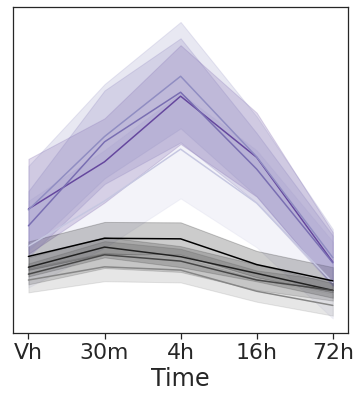

In [68]:
fig = plt.figure(figsize=[6,6])
gs = gridspec.GridSpec(nrows=1, ncols=1, left=0.06,wspace=0.4,top=0.8)

for i in range(4):
    subgenes = genes[clss == i+1]

    l = list(set(flatten([list(H.neighbors(a)) for a in subgenes if a in H.nodes])))
    arcre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'ARcre') & (l_ in foxar) ]

    cre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'cre') & (l_ in foxcre) ]

    l = list(set(flatten([list(H.neighbors(a)) for a in subgenes  if a in H.nodes])))
    cre_andr_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']






    for j, s in enumerate(['FOXA1']):
        #fig.add_subplot(gs[0, i])
        
        n = N[N.index.isin(arcre_andr_kac_fox)].drop_duplicates()
        n = n.stack().reset_index()
        tmp = n['level_1'].str.split('_', expand=True)

        n['Signal'] = tmp[0]
        n['Time'] = tmp[1]

        data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)[['Vh', '30m', '4h', '16h', '72h']]
        #sns.heatmap(data, cmap='Reds', vmax=120)
    
        plt.ylabel('')
        plt.xlabel('')
        plt.yticks([])
        
        sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color=color5[-i])
        print(color3[-i])

        n = N[N.index.isin(cre_andr_kac_fox)].drop_duplicates()
        n = n.stack().reset_index()
        tmp = n['level_1'].str.split('_', expand=True)

        n['Signal'] = tmp[0]
        n['Time'] = tmp[1]

        data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)[['Vh', '30m', '4h', '16h', '72h']]
        #sns.heatmap(data, cmap='Reds', vmax=120)
    
        plt.ylabel('')
        plt.xlabel('')
        plt.yticks([])
        
        sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color=color2[-i])
        print(color3[-i])

In [ ]:


#################################

        sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#888888')

        #fig.add_subplot(gs[1, i])
        n = N[N.index.isin(arcre_andr_kac_fox)].drop_duplicates()
        n = n.stack().reset_index()
        tmp = n['level_1'].str.split('_', expand=True)

        n['Signal'] = tmp[0]
        n['Time'] = tmp[1]

        data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)[['Vh', '30m', '4h', '16h', '72h']]
        #sns.heatmap(data, cmap='Reds', vmax=120)
        sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#F19220')
        plt.ylabel('')
        plt.xlabel('')
        plt.yticks([])
        plt.title(s, fontsize=30)

        plt.ylim(ylims[s])



    #fig.supylabel('TMM Normalized',fontsize=30)

    #fig.savefig('../plots/AR_epigenome_FINAL2.pdf', bbox_inches ="tight",  pad_inches = 1 )

In [8]:
mat[idx,:].shape

(107, 5)

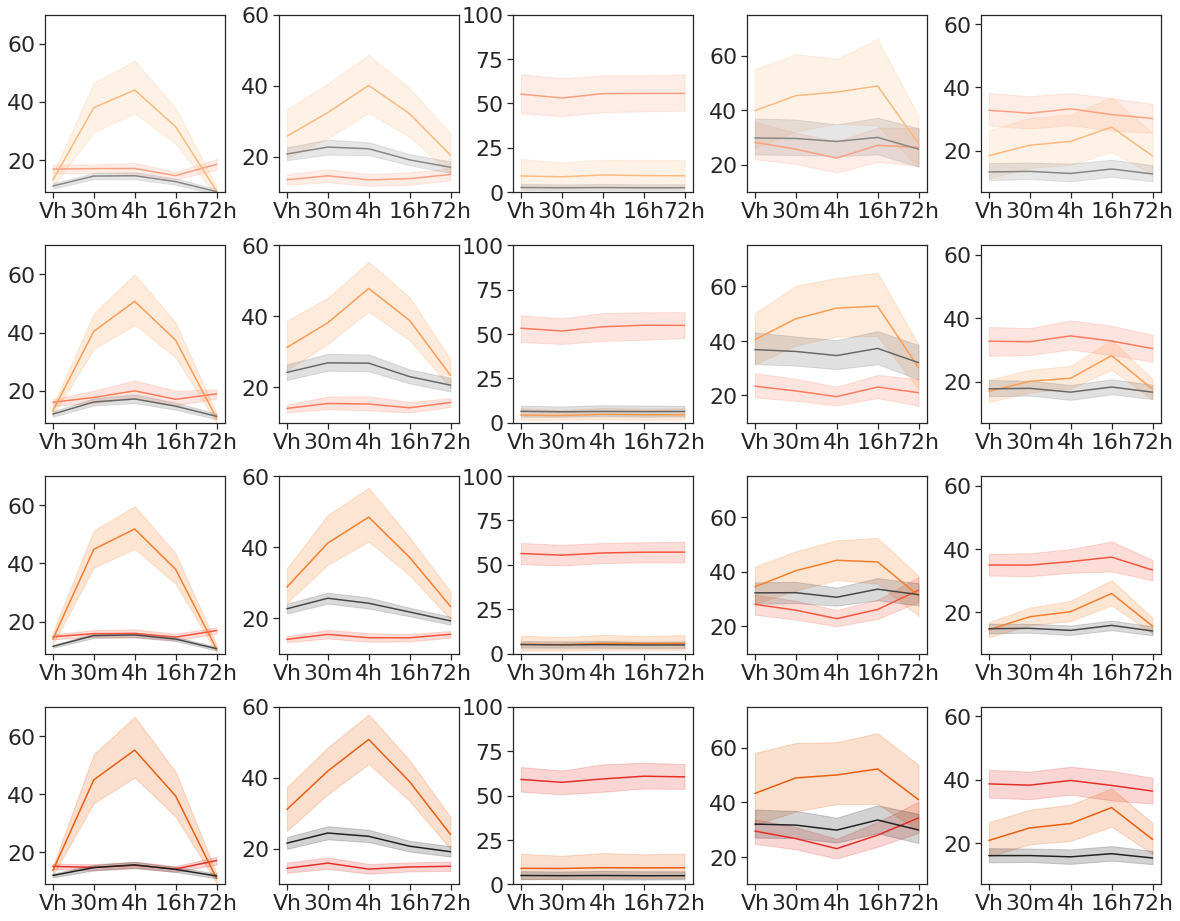

In [7]:
fig = plt.figure(figsize=[20,16])
gs = gridspec.GridSpec(nrows=4, ncols=5, wspace=0.3, hspace=0.3)


from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('Custom', ('#888888', '#e95e0d'), 2)
times = ['30m', '4h', '16h', '72h']


palettes= ['Oranges', 'Purples', 'Blues', 'Greens', 'Greys']
ylims = {'AR': (9,70), 'FOXA1': (10,60), 'H3K27ac': (10,75), 'H3K4me3': (0,100), 'ATAC': (7,63)}

for i in range(4):
	subgenes = genes[clss == i+1]

	l = list(set(flatten([list(H.neighbors(a)) for a in subgenes if a in H.nodes])))
	arcre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'ARcre') & (l_ in foxar) ]

	cre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'cre') & (l_ in foxcre) ]

	l = list(set(flatten([list(H.neighbors(a)) for a in subgenes  if a in H.nodes])))
	cre_andr_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']




	for j, s in enumerate(['AR', 'FOXA1','H3K4me3',  'H3K27ac', 'ATAC']):

		fig.add_subplot(gs[i, j])



		n = N[N.index.isin(subgenes)].drop_duplicates()
		n = n.stack().reset_index()
		tmp = n['level_1'].str.split('_', expand=True)
		n['Signal'] = tmp[0]
		n['Time'] = tmp[1]
		n['Set'] = n['Name'].map(MAPcl)

		data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)
		data = data[['Vh', '30m', '4h', '16h', '72h']].stack().reset_index()
	
		sns.lineplot(data=data, x='Time', y=0, color=color1[i])



		n = N[N.index.isin(arcre_andr_kac_fox)].drop_duplicates()
		n = n.stack().reset_index()
		tmp = n['level_1'].str.split('_', expand=True)
		n['Signal'] = tmp[0]
		n['Time'] = tmp[1]
		n['Set'] = n['Name'].map(MAPcl)

		data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)
		data = data[['Vh', '30m', '4h', '16h', '72h']].stack().reset_index()
	
		sns.lineplot(data=data, x='Time', y=0, color=color3[i])



		n = N[N.index.isin(cre_andr_kac_fox)].drop_duplicates()
		n = n.stack().reset_index()
		tmp = n['level_1'].str.split('_', expand=True)
		n['Signal'] = tmp[0]
		n['Time'] = tmp[1]
		n['Set'] = n['Name'].map(MAPcl)

		data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)
		data = data[['Vh', '30m', '4h', '16h', '72h']].stack().reset_index()
	
		sns.lineplot(data=data, x='Time', y=0, color=color2[i])
		plt.ylim(ylims[s])
		plt.xlabel('')
		plt.ylabel('')



In [9]:
subgenes.shape

(137,)

,Name,Time,0
0,chr10:135169029-135174029,Vh,20.011422
1,chr10:135169029-135174029,30m,15.780265
2,chr10:135169029-135174029,4h,23.343062
3,chr10:135169029-135174029,16h,15.924882
4,chr10:135169029-135174029,72h,27.980003
...,...,...,...
535,chr15:44098215-44103215,Vh,16.562926
536,chr15:44098215-44103215,30m,25.019895
537,chr15:44098215-44103215,4h,22.007516
538,chr15:44098215-44103215,16h,18.038279


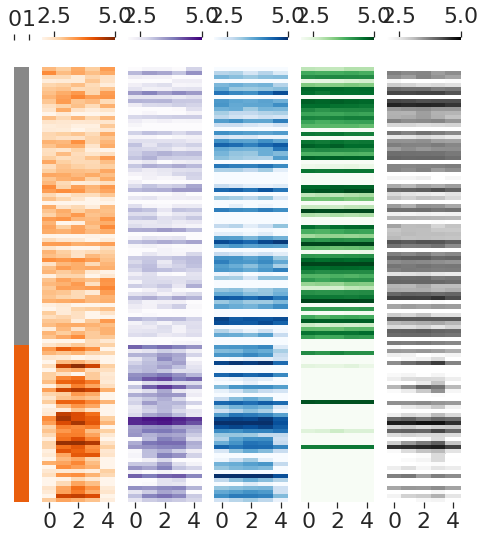

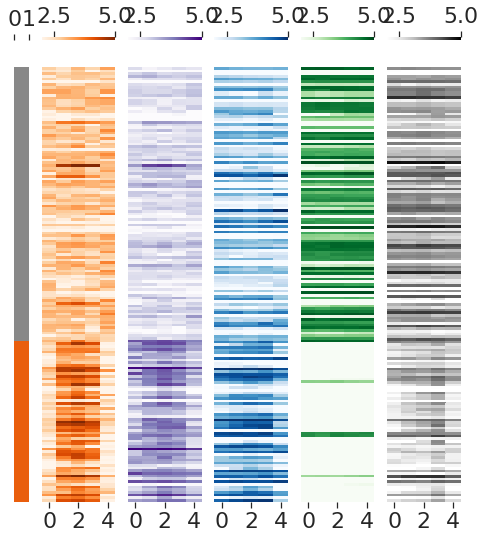

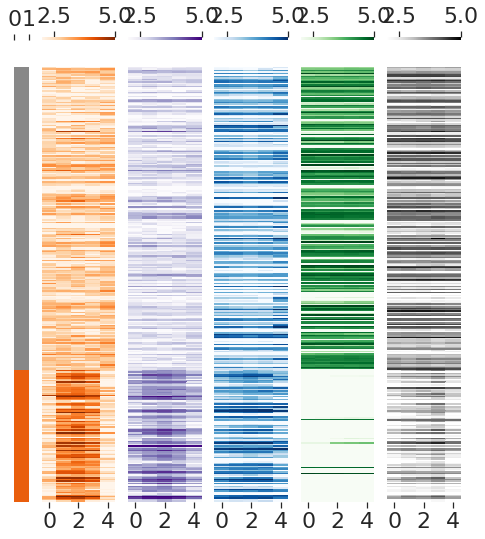

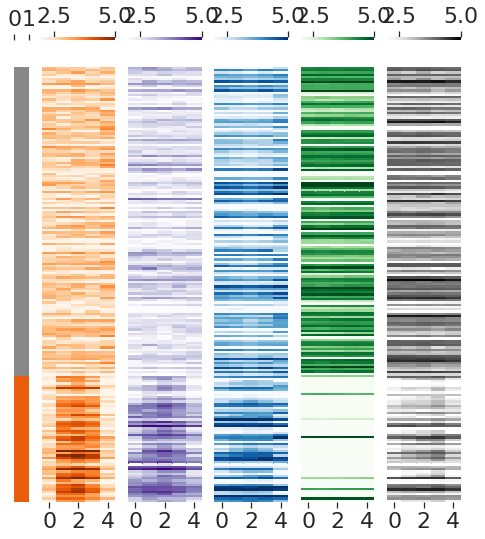

In [126]:

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('Custom', ('#888888', '#e95e0d'), 2)
times = ['30m', '4h', '16h', '72h']


palettes= ['Oranges', 'Purples', 'Blues', 'Greens', 'Greys']

for i in range(4):
	subgenes = genes[clss == i+1]

	fig = plt.figure(figsize=[8,10])
	gs = gridspec.GridSpec(nrows=1, ncols=6, width_ratios=[1,5,5,5,5,5])



	l = list(set(flatten([list(H.neighbors(a)) for a in subgenes if a in H.nodes])))
	arcre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'ARcre') & (l_ in foxar) ]

	cre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'cre') & (l_ in foxcre) ]

	l = list(set(flatten([list(H.neighbors(a)) for a in subgenes  if a in H.nodes])))
	cre_andr_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']

	n = N[N.index.isin(list(subgenes) + arcre_andr_kac_fox)].drop_duplicates()
	n = n.stack().reset_index()
	tmp = n['level_1'].str.split('_', expand=True)
	n['Signal'] = tmp[0]
	n['Time'] = tmp[1]
	n['Set'] = n['Name'].map(MAPcl)



	for j, s in enumerate(['AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'ATAC']):

		data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)
		data['Set'] = data.index.map(MAPcl)
		data['Sort'] = data['Set'] == 'ARcre'
		data = data.sort_values('Sort')[['Vh', '30m', '4h', '16h', '72h']]
		
		if j == 0:
			fig.add_subplot(gs[0])
			sns.heatmap(pd.DataFrame((data.index.map(MAPcl) == 'ARcre').astype(int)), cmap=cmap, cbar_kws = dict(use_gridspec=False,location="top"))
			
			plt.yticks([])

		fig.add_subplot(gs[j+1])

			
		mat = data.values
		idx = (mat == 0).sum(1) == 0

		sns.heatmap(np.log(mat[idx,:]), cmap=palettes[j], vmax=5, vmin=2,  cbar_kws = dict(use_gridspec=False,location="top"))
		plt.yticks([])

	fig.savefig(f"../plots/START_{times[i]}-Epigenome.pdf", bbox_inches="tight", pad_inches=1)

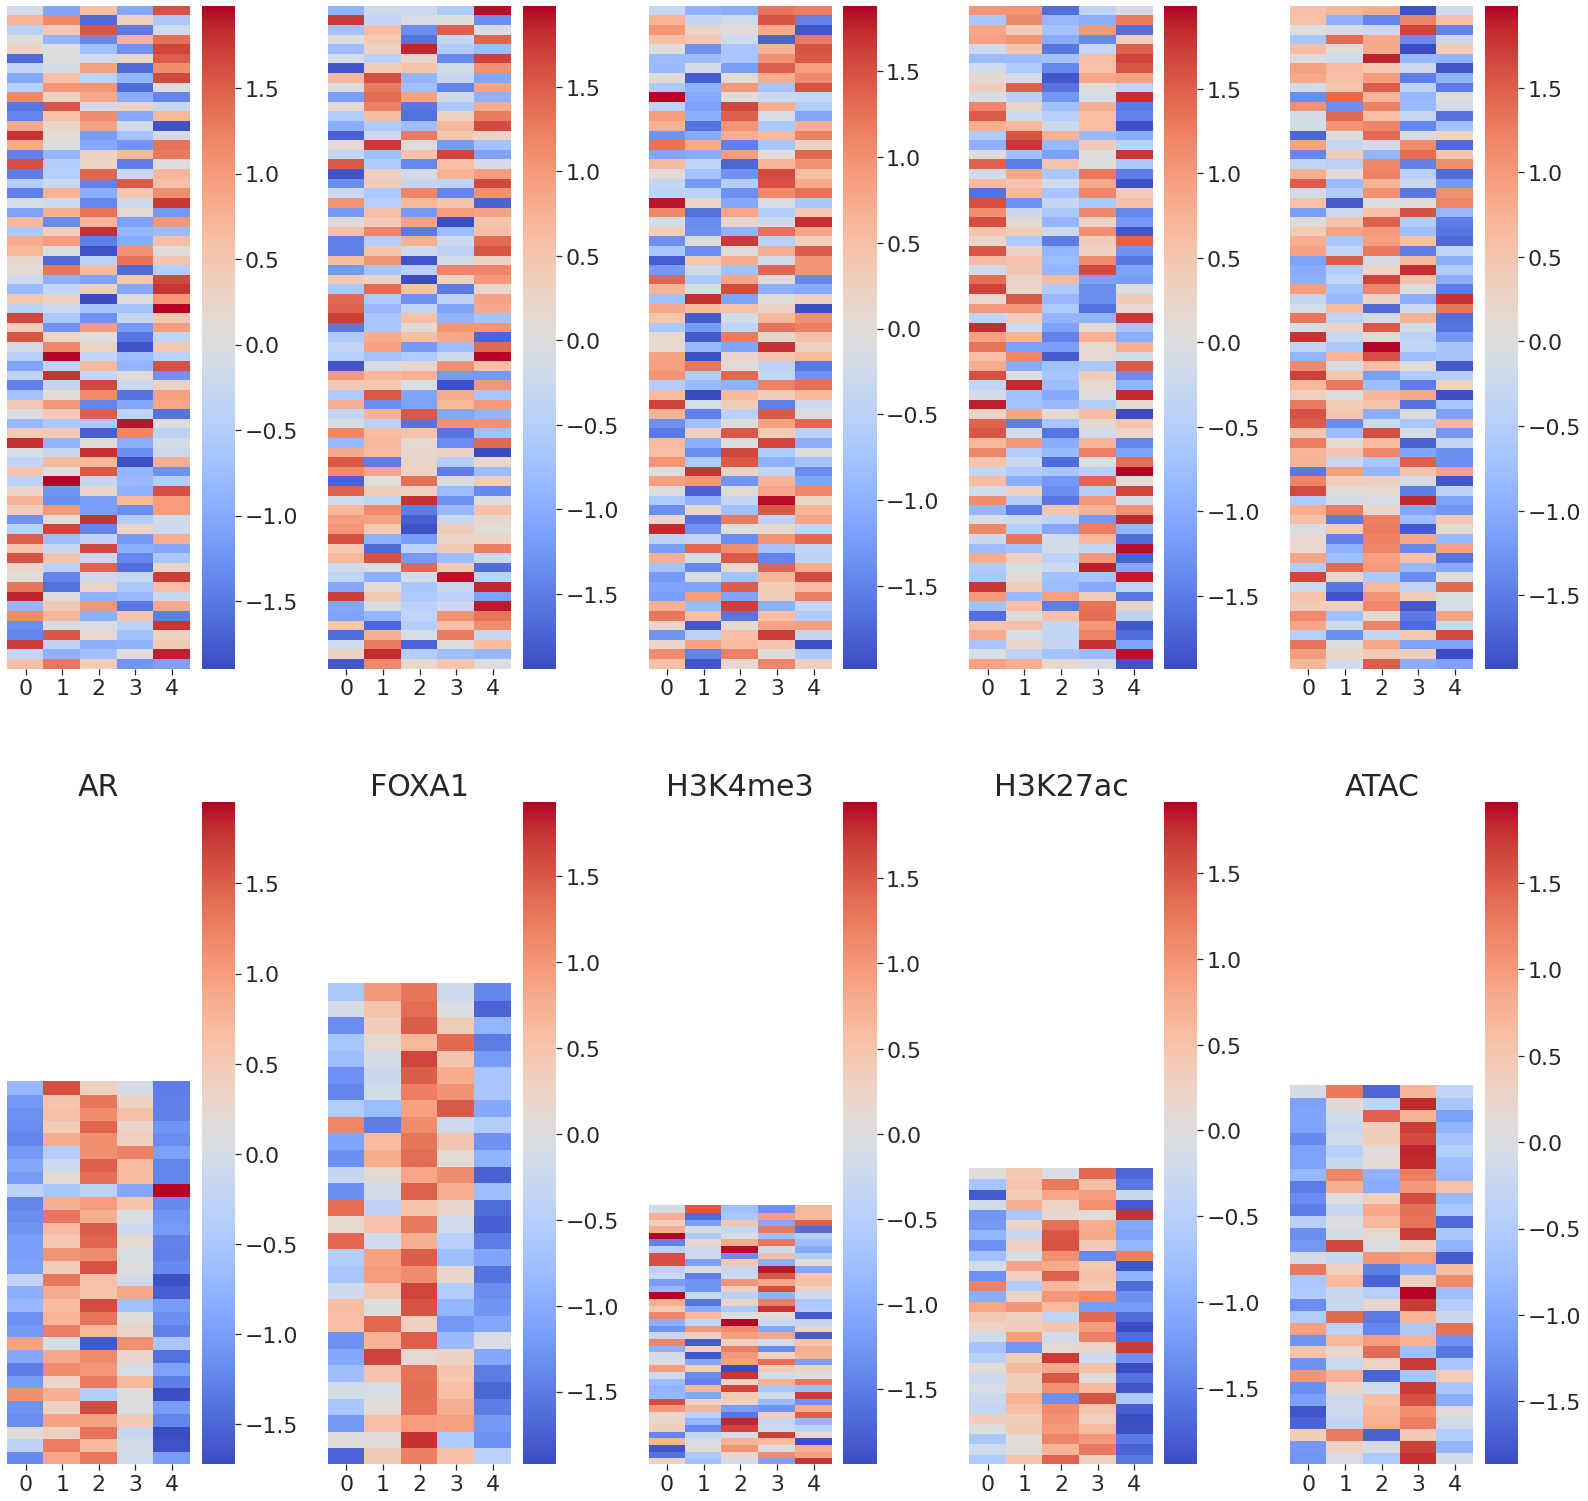

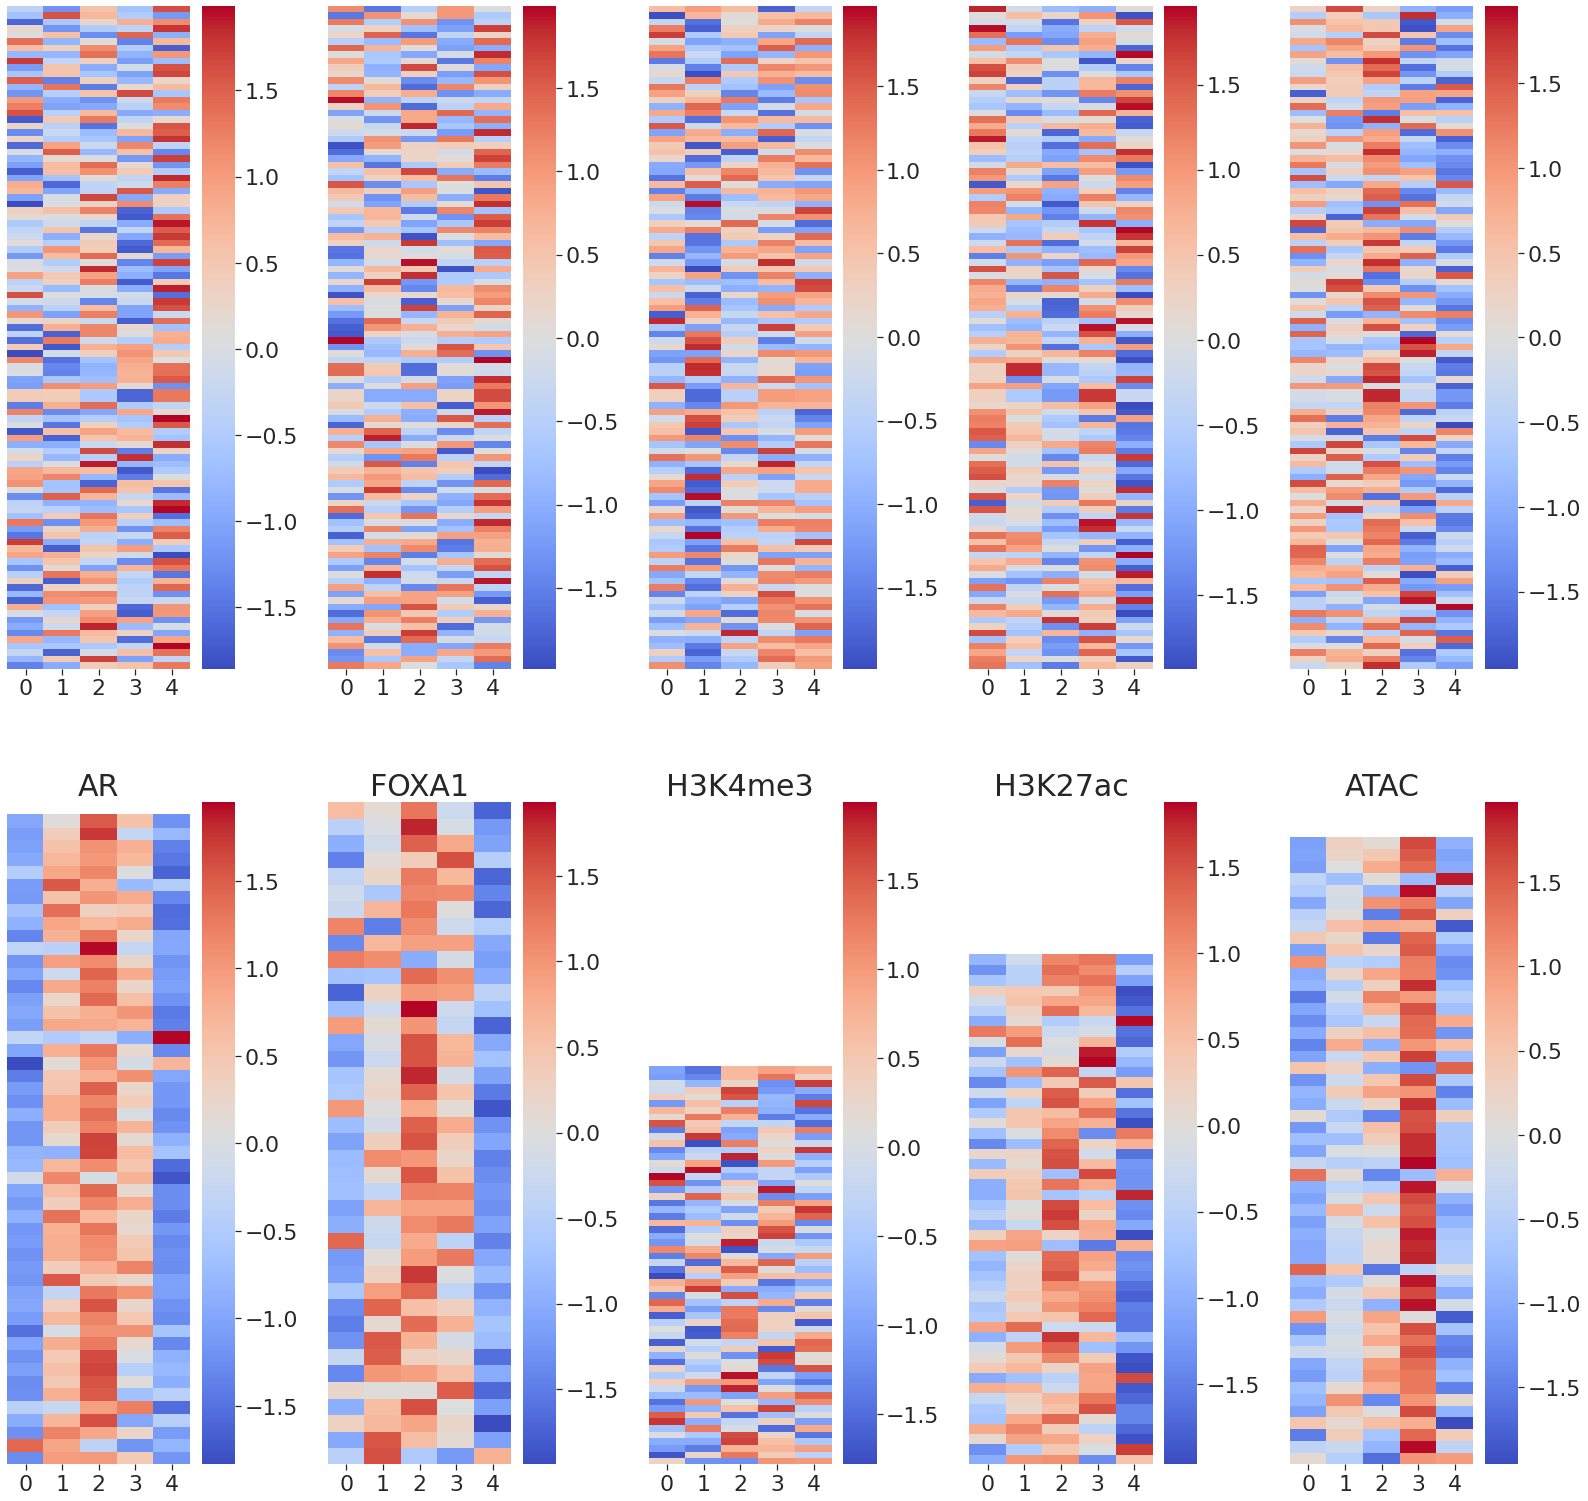

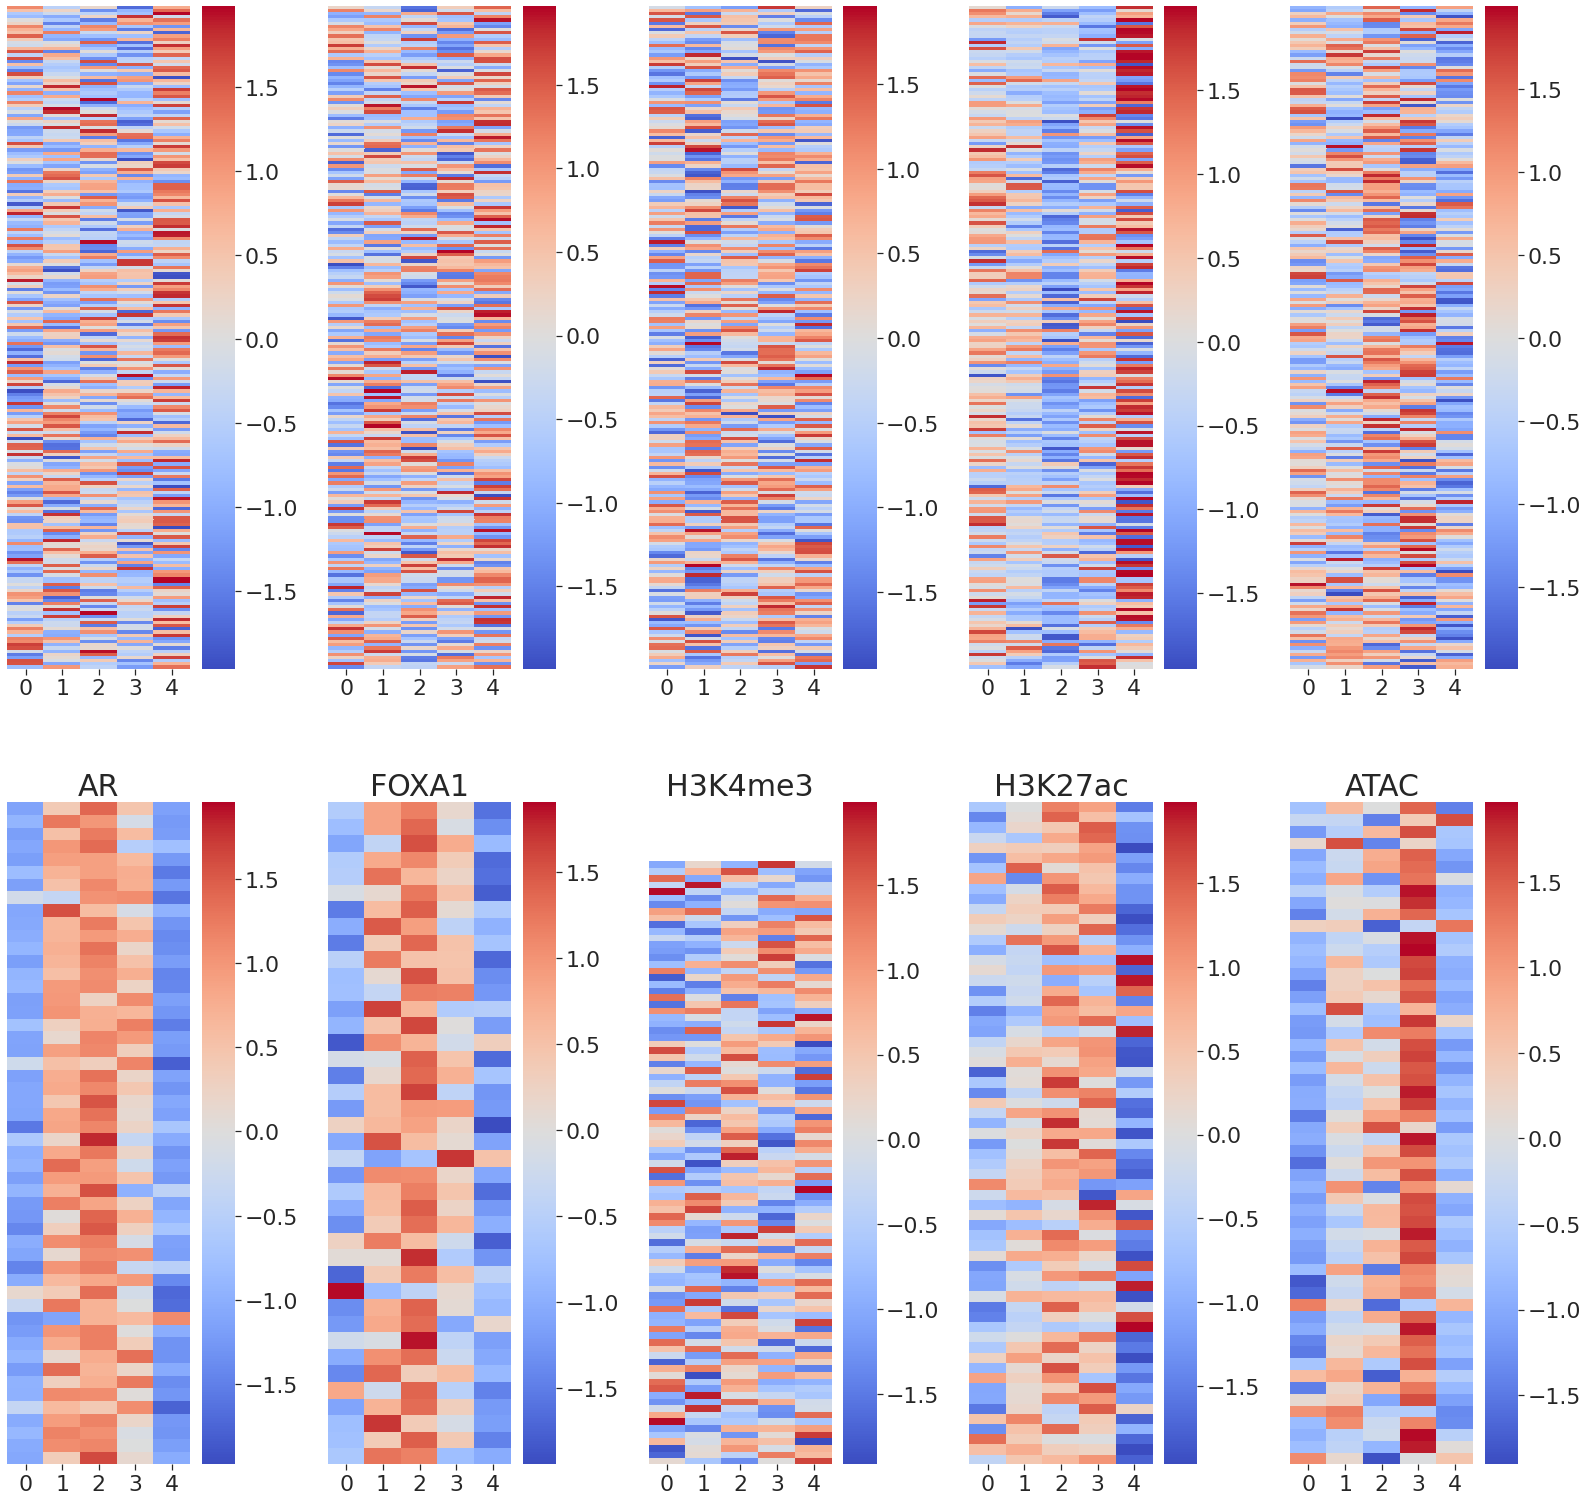

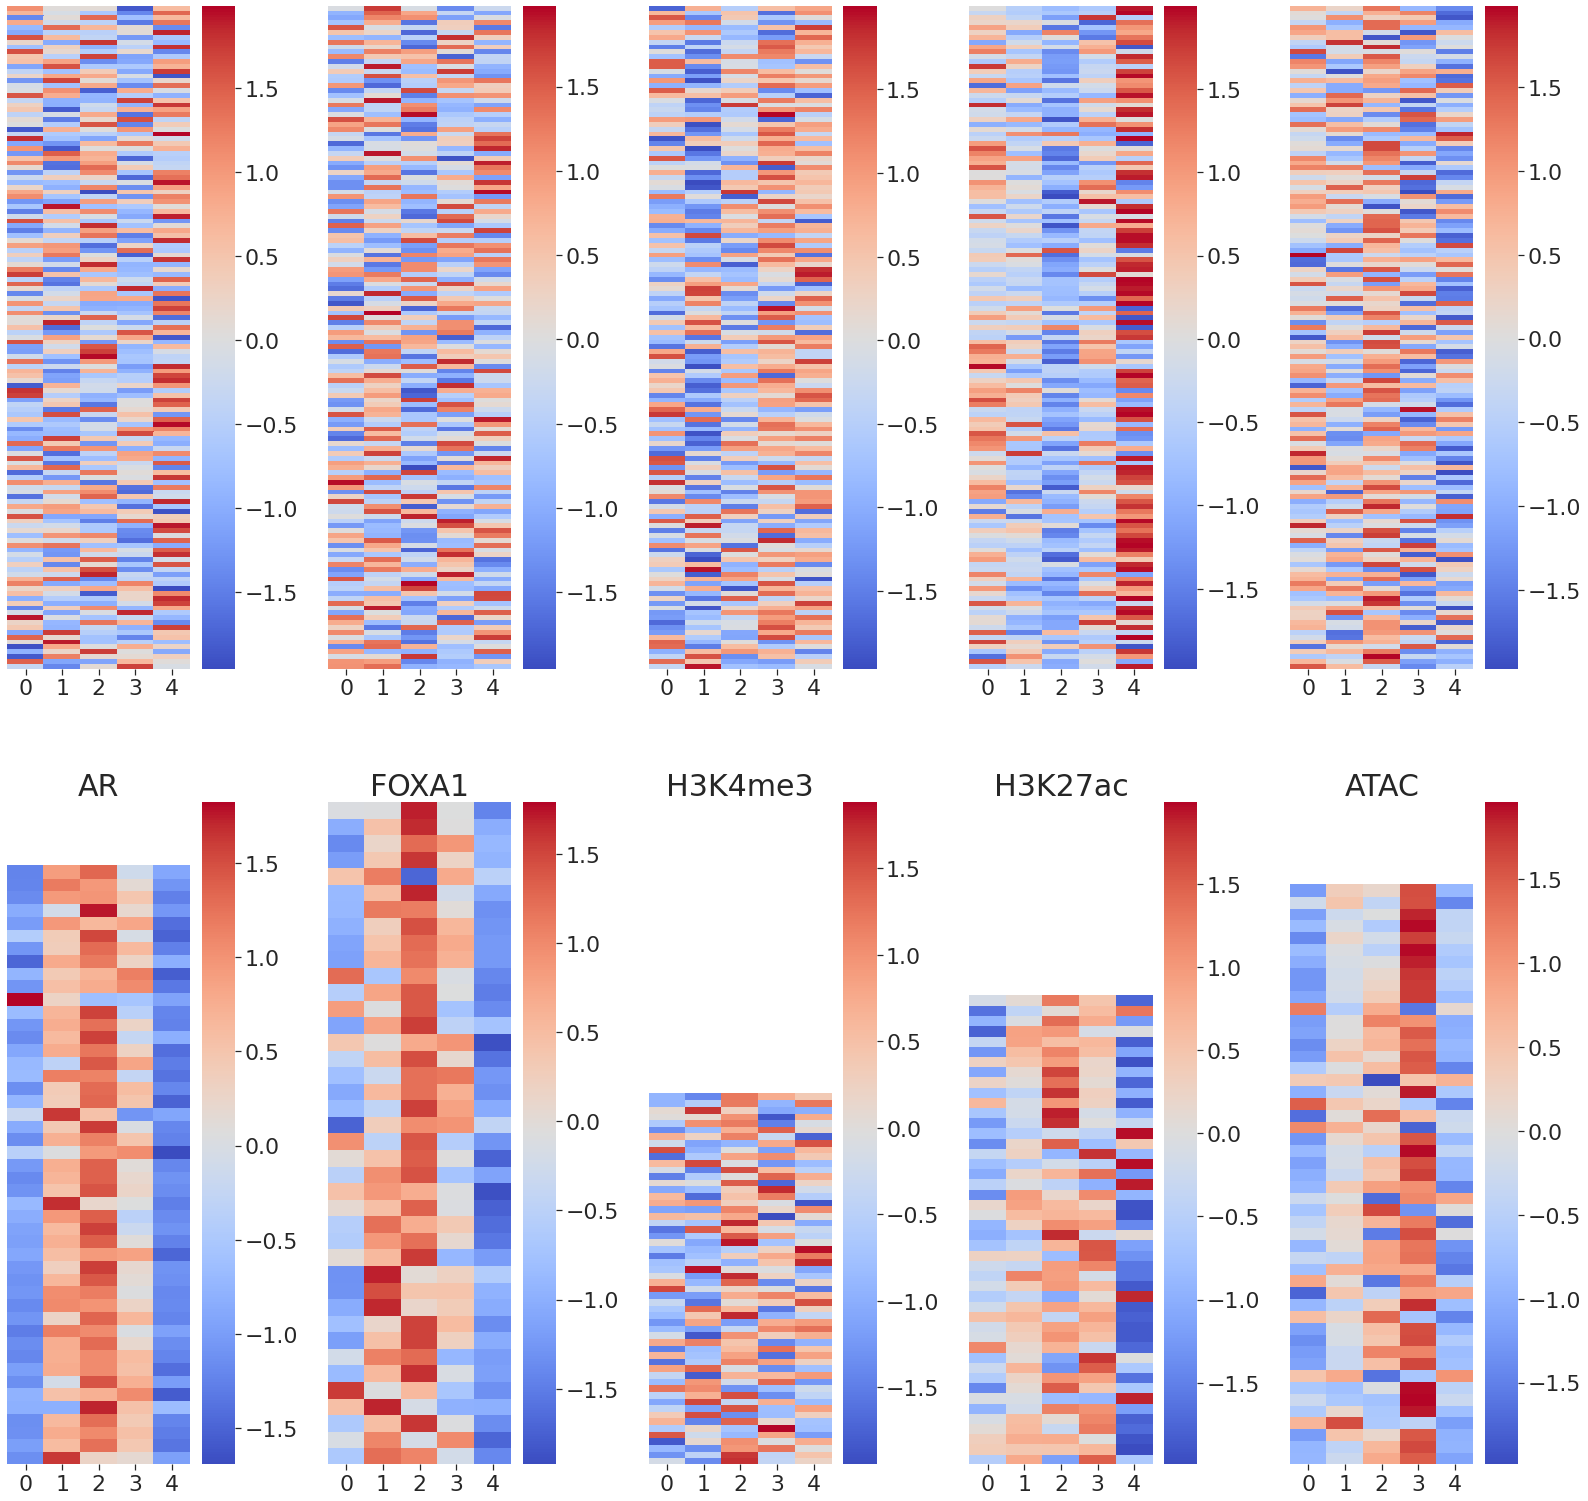

In [27]:


for i in range(4):
    subgenes = genes[clss == i+1]

    l = list(set(flatten([list(H.neighbors(a)) for a in subgenes if a in H.nodes])))
    arcre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'ARcre') & (l_ in foxar) ]

    cre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'cre') & (l_ in foxcre) ]

    l = list(set(flatten([list(H.neighbors(a)) for a in subgenes  if a in H.nodes])))
    cre_andr_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']


    fig = plt.figure(figsize=[25,30])
    gs = gridspec.GridSpec(nrows=2, ncols=5, left=0.06,wspace=0.4,top=0.8)

    ylims = {'AR': (9,61), 'FOXA1': (10,50), 'H3K27ac': (10,75), 'H3K4me3': (0,100), 'ATAC': (7,63)}

    for i, s in enumerate(['AR', 'FOXA1', 'H3K4me3', 'H3K27ac', 'ATAC']):
        fig.add_subplot(gs[0, i])
        
        n = N[N.index.isin(subgenes + arcre_andr_kac_fox)].drop_duplicates()
        n = n.stack().reset_index()
        tmp = n['level_1'].str.split('_', expand=True)

        n['Signal'] = tmp[0]
        n['Time'] = tmp[1]
        n['Set'] = n['Name'].map(MAPcl)

        data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)[['Vh', '30m', '4h', '16h', '72h']]
        
        
        data.index.map(MAPcl)

        mat = data.values.T
        mat = (mat - mat.mean(0)) / mat.std(0)
        mat = mat.T

        sns.heatmap(mat, cmap='coolwarm')




        
    
        plt.ylabel('')
        plt.xlabel('')
        plt.yticks([])
        


        #sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#DA0000')

        fig.add_subplot(gs[1, i])
        n = N[N.index.isin(arcre_andr_kac_fox)].drop_duplicates()
        n = n.stack().reset_index()
        tmp = n['level_1'].str.split('_', expand=True)

        n['Signal'] = tmp[0]
        n['Time'] = tmp[1]

        data=n[n['Signal'] == s].pivot(columns='Time', index='Name', values=0)[['Vh', '30m', '4h', '16h', '72h']]

        mat = data.values.T
        mat = (mat - mat.mean(0)) / mat.std(0)
        mat = mat.T

        sns.heatmap(mat, cmap='coolwarm')
        #sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#F19220')
        plt.ylabel('')
        plt.xlabel('')
        plt.yticks([])
        plt.title(s, fontsize=30)

        plt.ylim(ylims[s])



    #fig.supylabel('TMM Normalized',fontsize=30)

    #fig.savefig('../plots/AR_epigenome_FINAL2.pdf', bbox_inches ="tight",  pad_inches = 1 )

In [31]:
data

Time,Vh,30m,4h,16h,72h
Name,,,,,
chr10:106035083-106040083,11.021124,13.712998,13.863444,16.725985,11.388291
chr10:106045746-106050746,5.350980,11.715284,10.178937,11.695778,8.492831
chr11:128321200-128326200,27.318760,39.667203,47.386000,45.536494,30.993451
chr11:62352939-62357939,2.067039,5.379299,11.686982,20.700979,4.651147
chr12:123880814-123885814,15.588474,22.950982,38.844767,38.082382,18.250797
chr12:133402670-133407670,58.839878,68.487511,81.565038,89.167810,63.245315
chr15:42560798-42565798,32.689604,31.475570,22.678124,39.815774,44.108985
chr15:61042761-61047761,8.157415,10.901309,15.495809,18.491291,7.109977
chr15:61204007-61209007,8.027961,10.319528,15.172392,19.725662,7.911351


In [29]:
mat.shape

(56, 5)

In [30]:
mat.std(0)

array([0.74742421, 0.42656077, 0.83784414, 0.91166351, 0.64903911])

In [25]:
n

,Name,level_1,0,Signal,Time
0,chr1:10693238-10698238,ATAC_Vh,31.494057,ATAC,Vh
1,chr1:10693238-10698238,ATAC_30m,35.808334,ATAC,30m
2,chr1:10693238-10698238,ATAC_4h,43.745053,ATAC,4h
3,chr1:10693238-10698238,ATAC_16h,57.939661,ATAC,16h
4,chr1:10693238-10698238,ATAC_72h,32.512532,ATAC,72h
...,...,...,...,...,...
1675,chrX:54955287-54960287,FOXA1_Vh,16.545273,FOXA1,Vh
1676,chrX:54955287-54960287,FOXA1_30m,22.606739,FOXA1,30m
1677,chrX:54955287-54960287,FOXA1_4h,29.463408,FOXA1,4h
1678,chrX:54955287-54960287,FOXA1_16h,24.722908,FOXA1,16h


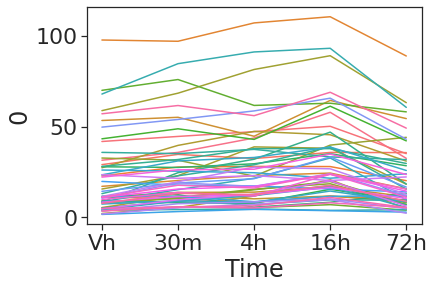

In [22]:
sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#DA0000', hue='Name')
plt.legend([], frameon=False)

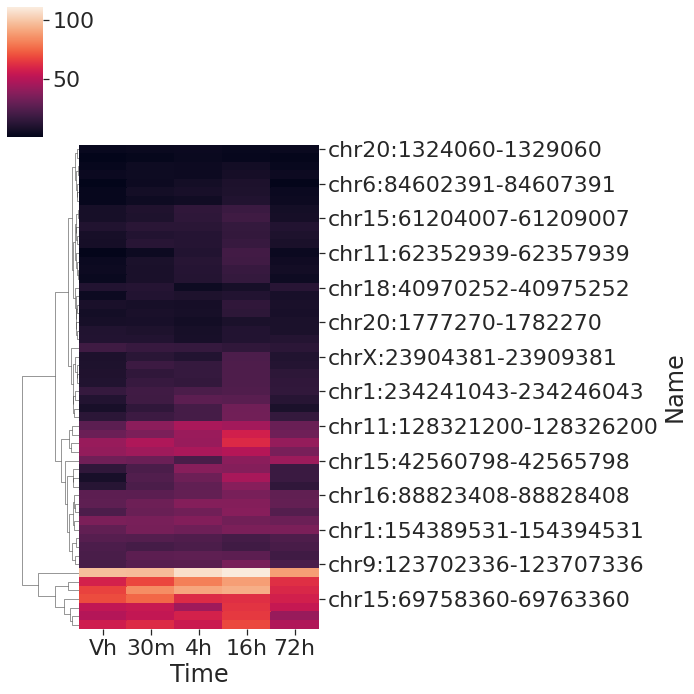